# <center>Домашнее задание № 3. <br>Деревья решений в игрушечной задаче и на данных Adult репозитория UCI

**В задании Вам предлагается разобраться с тем, как работает дерево решений, на игрушечном примере, затем обучить и настроить деревья и (при желании) случайный лес в задаче классификации на данных Adult репозитория UCI.

Подключаем необходимые библиотеки

In [19]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = (10, 8)
import collections

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## Часть 1. Игрушечный набор данных "девушка в баре"

**Цель –  "на пальцах", с помощью игрушечной задачи классификации разобраться в том, как работают деревья решений. Само по себе дерево решений – довольно слабый алгоритм, но основанные на нем алгоритмы случайного леса и градиентного бустинга - пожалуй, лучшее, что есть на сегодняшний день (в задачах, где можно обойтись без нейронных сетей). Поэтому разобраться в том, как работает дерево решений, полезно.**

**Рассмотрим игрушечную задачу бинарной классификации: поедет ли с Вами девушка из бара? Это будет зависеть от Вашей внешности и красноречия, крепости предлагаемых напитков и, как это ни меркантильно, от количества потраченных в баре денег.**
<img src='toy_data.png'>

### Создание набора данных

In [ ]:
# Создание датафрейма с dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis = 1)
    out.drop(feature_list, axis = 1, inplace = True)
    return out

# Некоторые значения признаков есть в тесте, но нет в трейне и наоборот
def intersect_features(train, test):
    common_feat = list( set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [ ]:
features = ['Внешность', 'Алкоголь_в_напитке',
            'Уровень_красноречия', 'Потраченные_деньги']

**Обучающая выборка**

In [ ]:
df_train = {}
df_train['Внешность'] = ['приятная', 'приятная', 'приятная', 'отталкивающая',
                         'отталкивающая', 'отталкивающая', 'приятная']
df_train['Алкоголь_в_напитке'] = ['да', 'да', 'нет', 'нет', 'да', 'да', 'да']
df_train['Уровень_красноречия'] = ['высокий', 'низкий', 'средний', 'средний', 'низкий',
                                   'высокий', 'средний']
df_train['Потраченные_деньги'] = ['много', 'мало', 'много', 'мало', 'много',
                                  'много', 'много']
df_train['Поедет'] = LabelEncoder().fit_transform(['+', '-', '+', '-', '-', '+', '+'])

df_train = create_df(df_train, features)
df_train

,Поедет,Внешность_отталкивающая,Внешность_приятная,Алкоголь_в_напитке_да,Алкоголь_в_напитке_нет,Уровень_красноречия_высокий,Уровень_красноречия_низкий,Уровень_красноречия_средний,Потраченные_деньги_мало,Потраченные_деньги_много
0,0,False,True,True,False,True,False,False,False,True
1,1,False,True,True,False,False,True,False,True,False
2,0,False,True,False,True,False,False,True,False,True
3,1,True,False,False,True,False,False,True,True,False
4,1,True,False,True,False,False,True,False,False,True
5,0,True,False,True,False,True,False,False,False,True
6,0,False,True,True,False,False,False,True,False,True


**Тестовая выборка**

In [ ]:
df_test = {}
df_test['Внешность'] = ['приятная', 'приятная', 'отталкивающая']
df_test['Алкоголь_в_напитке'] = ['нет', 'да', 'да']
df_test['Уровень_красноречия'] = ['средний', 'высокий', 'средний']
df_test['Потраченные_деньги'] = ['много', 'мало', 'много']
df_test = create_df(df_test, features)
df_test

,Внешность_отталкивающая,Внешность_приятная,Алкоголь_в_напитке_да,Алкоголь_в_напитке_нет,Уровень_красноречия_высокий,Уровень_красноречия_средний,Потраченные_деньги_мало,Потраченные_деньги_много
0,False,True,False,True,False,True,False,True
1,False,True,True,False,True,False,True,False
2,True,False,True,False,False,True,False,True


In [ ]:
# Некоторые значения признаков есть в тесте, но нет в трейне и наоборот
y = df_train['Поедет']
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Уровень_красноречия_средний,Алкоголь_в_напитке_нет,Внешность_приятная,Уровень_красноречия_высокий,Потраченные_деньги_много,Внешность_отталкивающая,Потраченные_деньги_мало,Алкоголь_в_напитке_да
0,False,False,True,True,True,False,False,True
1,False,False,True,False,False,False,True,True
2,True,True,True,False,True,False,False,False
3,True,True,False,False,False,True,True,False
4,False,False,False,False,True,True,False,True
5,False,False,False,True,True,True,False,True
6,True,False,True,False,True,False,False,True


In [ ]:
df_test

,Уровень_красноречия_средний,Алкоголь_в_напитке_нет,Внешность_приятная,Уровень_красноречия_высокий,Потраченные_деньги_много,Внешность_отталкивающая,Потраченные_деньги_мало,Алкоголь_в_напитке_да
0,True,True,True,False,True,False,False,False
1,False,False,True,True,False,False,True,True
2,True,False,False,False,True,True,False,True


**Постройте от руки (или в графическом редакторе) дерево решений для этого набора данных. Дополнительно (для желающих) – можете сделать отрисовку дерева и написать код для построения всего дерева.**

<font color='red'>Вопрос 1.</font> Какова энтропия начальной системы ($S_0$)? Под состояниями системы понимаем значения признака "Поедет" – 0 или 1 (то есть всего 2 состояния).

In [ ]:
u = df_train['Поедет'].value_counts(normalize=True).values
-np.sum(u * np.log2(u))

0.9852281360342515

<font color='red'>Вопрос 2. </font> Рассмотрим разбиение обучающей выборки по признаку "Внешность\_приятная". Какова энтропия  $S_1$ левой группы, тех, у кого внешность приятная, и правой группы – $S_2$? Каков прирост информации  при данном разбиении (IG)?

In [ ]:
s1 = df_train[df_train['Внешность_отталкивающая'] == True]['Поедет'].value_counts(normalize=True).values
print(-np.sum(s1 * np.log2(s1)))
s2 = df_train[df_train['Внешность_приятная'] == True]['Поедет'].value_counts(normalize=True).values
print(-np.sum(s2 * np.log2(s2)))

0.9182958340544896
0.8112781244591328


**Постройте с помощью `sklearn` дерево решений, обучив его на обучающей выборке. Глубину можно не ограничивать.**

In [ ]:
X = df_train.drop(columns=['Поедет'])
y = df_train['Поедет']

qwe = DecisionTreeClassifier()

qwe.fit(X, y)

y_pred = qwe.predict(X)

print(qwe)
accuracy = accuracy_score(y, y_pred)
print("Accuracy:", accuracy)

DecisionTreeClassifier()
Accuracy: 1.0


**Дополнительно: отобразите дерево с помощью graphviz. Можно использовать `pydot` или, например, [онлайн-сервис](https://www.coolutils.com/ru/online/DOT-to-PNG) dot2png.**

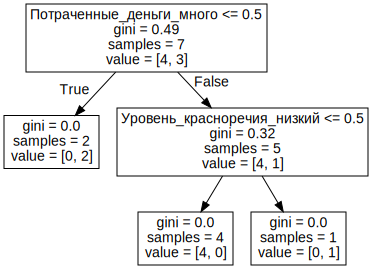

In [ ]:
import graphviz
import pydotplus
from IPython.display import Image
from sklearn import tree
# export_graphviz(qwe, out_file='tree.dot', feature_names=X.columns, filled=True,)
# dot_data = StringIO()
wer = tree.export_graphviz(qwe, out_file=None, feature_names=X.columns)
# graph = pydotplus.graph_from_dot_data("treee.dot")
# graph.write_png('treee.png')
# # Image(graph.create_png())
# dot -Tps tree.dot -o tree.ps
graph = graphviz.Source(wer)
graph

## Часть 2. Функции для расчета энтропии и прироста информации

Примерчик для проверки: 9 синих шариков и 11 желтых. Пусть шарик находится в состоянии "1", если он синий и "0" – если он желтый.

In [ ]:
balls = [1 for i in range(9)] + [0 for i in range(11)]

![png](../../img/decision_tree3.png)

Дальше пусть шарики разбиваются на 2 группы
![png](../../img/decision_tree4.png)

In [ ]:
# две группы
balls_left  = [1 for i in range(8)] + [0 for i in range(5)] # 8 синих и 5 желтых
balls_right = [1 for i in range(1)] + [0 for i in range(6)] # 1 синий и 6 желтых

**Реализуйте функцию для расчета энтропии Шеннона.**

In [ ]:
def entropy(a_list):
    u = pd.DataFrame(a_list).value_counts(normalize=True).values
    return -np.sum(u * np.log2(u))

Проверка

In [ ]:
print(entropy(balls)) # 9 синих и 11 желтых
print(entropy(balls_left)) # 8 синих и 5 желтых
print(entropy(balls_right)) # 1 синий и 6 желтых
print(entropy([1,2,3,4,5,6])) # энтропия игральной кости с несмещенным центром тяжести

0.9927744539878083
0.9612366047228759
0.5916727785823275
2.584962500721156


<font color='red'>Вопрос 3.</font> Чему равна энтропия состояния, заданного списком `balls_left`?

In [ ]:
print(entropy(balls_left)) # 8 синих и 5 желтых


0.9612366047228759


<font color='red'>Вопрос 4.</font> Чему равна энтропия игральной кости с несмещенным центром тяжести?

In [ ]:
print(entropy([1,2,3,4,5,6])) # энтропия игральной кости с несмещенным центром тяжести

2.584962500721156


<font color='red'>Вопрос 5.  </font> Каков прирост информации при разделении выборки на `balls_left` и `balls_right`?

In [ ]:
def information_gain(root, left, right):
    ''' root - изначальный набор данных, left и right два разбиения изначального набора'''
    return (entropy(balls) * len(balls) - entropy(balls_left) * len(balls_left) - entropy(balls_right) * len(balls_right))/len(balls)

information_gain(balls, balls_left, balls_right)

0.1608851884141243

**Опционально:**

 - реализуйте алгоритм построения дерева за счет рекурсивного вызова функции `best_feature_to_split`
 - нарисуйте полученное дерево

[[ True  True]
 [ True False]
 [False  True]
 [False False]
 [ True  True]
 [ True  True]
 [ True  True]] 0    0
1    1
2    0
3    1
4    1
5    0
6    0
Name: Поедет, dtype: int64


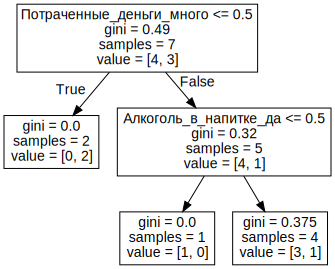

In [ ]:
def best_feature_to_split(X, y):
    ''' Выводит прирост информации при разбиении по каждому признаку'''
    if entropy(X) != 0:
        for i in range(len(X)):
            entropy(X[:i]) * len(y) - entropy(X[i:]) * len(y)
    else:
        return 0

# X = df_train.drop(columns=['Поедет'])

def build(L):
    #create node t
    t = DecisionTreeClassifier()
    if entropy(X) != 0:
        #assign a predictive model to t
        t.predict(X)
    else:
        #Find the best binary split L = L_left + L_right
        t.left = build(L_left)
        t.right = build(L_right)
    return t

X = df_train[['Алкоголь_в_напитке_да', 'Потраченные_деньги_много']].values
y = df_train['Поедет']

qwe = DecisionTreeClassifier()

qwe.fit(X, y)
print(X, y)

wer = tree.export_graphviz(qwe, out_file=None, feature_names=['Алкоголь_в_напитке_да', 'Потраченные_деньги_много'])

graph = graphviz.Source(wer)
graph

# best_feature_to_split(df_test, y)

## Часть 3. Набор данных "Adult"

**Описание набора:**

**[Набор](http://archive.ics.uci.edu/ml/machine-learning-databases/adult) данных UCI Adult** (качать не надо, все есть в репозитории): классификация людей с помощью демографических данных для прогнозирования, зарабатывает ли человек более \$ 50 000 в год.

Описание признаков:

**Age** – возраст, количественный признак  
**Workclass** – тип работодателя, количественный признак  
**fnlwgt** – итоговый вес обьекта, количественный признак    
**Education** – уровень образования, качественный признак  
**Education_Num** – количество лет обучения, количественный признак  
**Martial_Status** – семейное положение, категориальный признак  
**Occupation** – профессия, категориальный признак  
**Relationship** – тип семейных отношений, категориальный признак    
**Race** – раса, категориальный признак  
**Sex** – пол, качественный признак  
**Capital_Gain** – прирост капитала, количественный признак  
**Capital_Loss** – потери капитала, количественный признак  
**Hours_per_week** – количество часов работы в неделю, количественный признак  
**Country** – страна, категориальный признак  
   
Целевая переменная: **Target** – уровень заработка, категориальный (бинарный) признак  

**Считываем обучающую и тестовую выборки.**

In [112]:
data_train = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', sep=',')
data_train.columns = ['Age', 'Workclass', 'fnlwgt', 'Education', 'Education_Num',
                      'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex',
                      'Capital_Gain', 'Capital_Loss', 'Hours_per_week', 'Country', 'Target']

In [113]:
data_train.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32559,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [116]:
data_test = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', sep=',', skiprows=1)
data_test.columns = ['Age', 'Workclass', 'fnlwgt', 'Education', 'Education_Num',
                      'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex',
                      'Capital_Gain', 'Capital_Loss', 'Hours_per_week', 'Country', 'Target']

In [117]:
data_test.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
16275,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
16276,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K.
16277,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
16278,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.
16279,35,Self-emp-inc,182148,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,60,United-States,>50K.


In [118]:
# необходимо убрать строки с неправильными метками в тестовой выборке
data_test = data_test[(data_test['Target'] == ' >50K.')
                      | (data_test['Target']==' <=50K.')]

# перекодируем target в числовое поле
data_train.loc[data_train['Target'] == ' <=50K', 'Target'] = 0
data_train.loc[data_train['Target'] == ' >50K', 'Target'] = 1

data_test.loc[data_test['Target'] == ' <=50K.', 'Target'] = 0
data_test.loc[data_test['Target'] == ' >50K.', 'Target'] = 1

**Первичный анализ данных.**

In [119]:
data_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16280.0,NaN,NaN,NaN,38.768305,13.849192,17.0,28.0,37.0,48.0,90.0
Workclass,16280,9,Private,11209,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16280.0,NaN,NaN,NaN,189433.382555,105717.748915,13492.0,116716.25,177829.5,238384.0,1490400.0
Education,16280,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16280.0,NaN,NaN,NaN,10.073096,2.567511,1.0,9.0,10.0,12.0,16.0
Martial_Status,16280,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,16280,15,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16280,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16280,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16280,2,Male,10859,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
data_train['Target'].value_counts()

Target
0    24719
1     7841
Name: count, dtype: int64

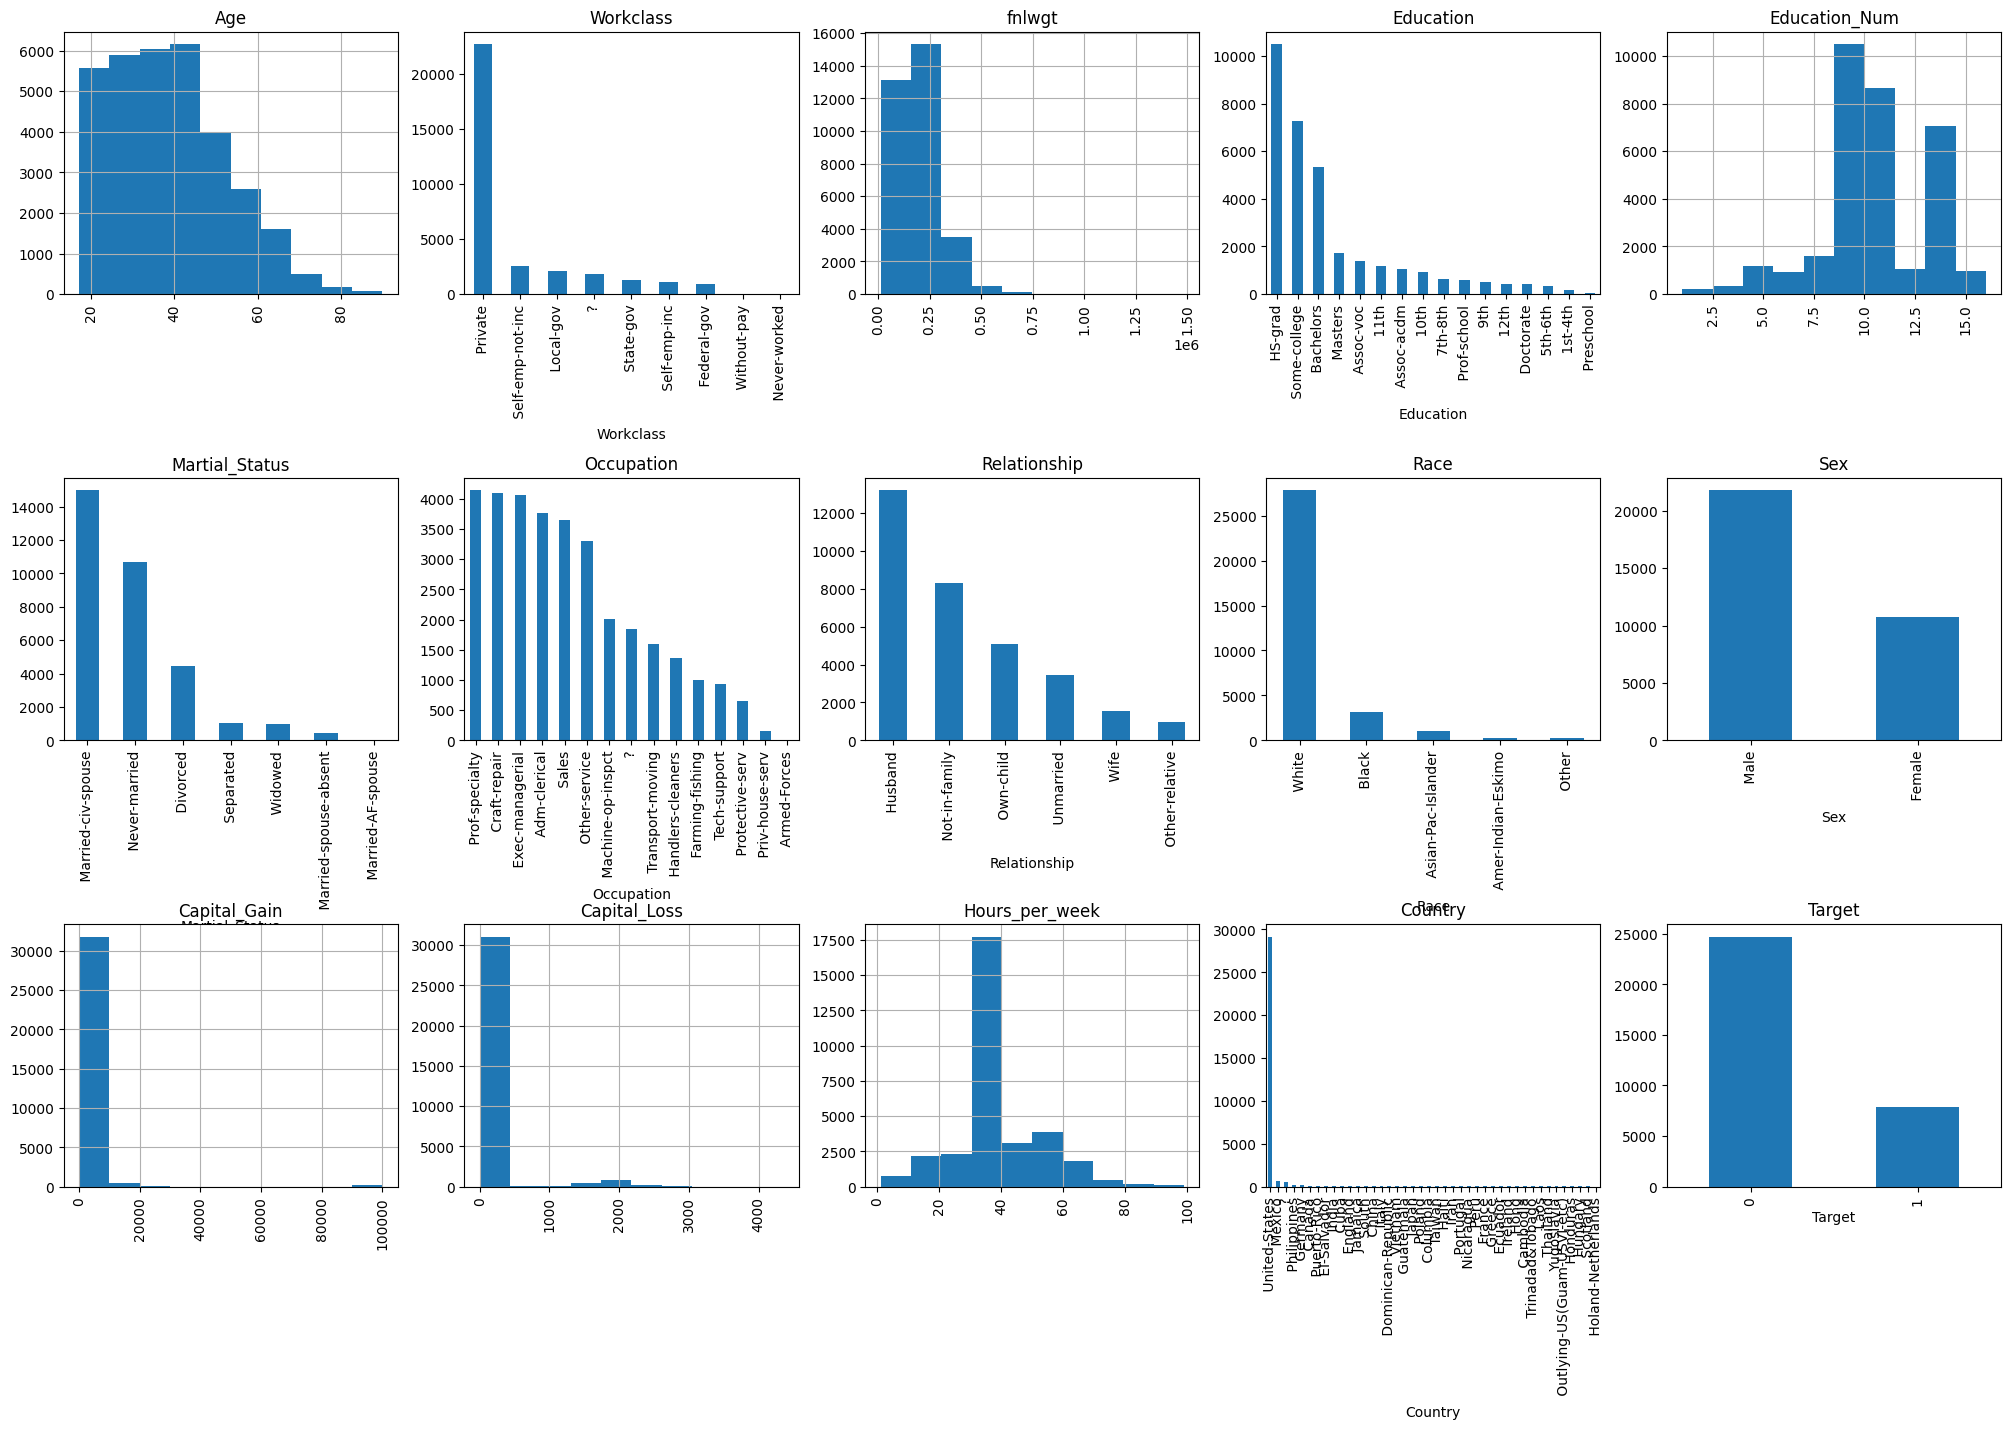

In [121]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = int(np.ceil(float(data_train.shape[1]) / cols))
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == object:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

**Проверяем типы данных**

In [122]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target            object
dtype: object

In [123]:
data_test.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target            object
dtype: object

Выяснилось, что в тесте возраст отнесен к типу object, необходимо это исправить.

In [124]:
data_test['Age'] = data_test['Age'].astype(int)

Также приведем показатели типа float в int для соответствия train и test выборок.

In [125]:
data_test['fnlwgt'] = data_test['fnlwgt'].astype(int)
data_test['Education_Num'] = data_test['Education_Num'].astype(int)
data_test['Capital_Gain'] = data_test['Capital_Gain'].astype(int)
data_test['Capital_Loss'] = data_test['Capital_Loss'].astype(int)
data_test['Hours_per_week'] = data_test['Hours_per_week'].astype(int)

**Заполним пропуски в количественных полях медианными значениями, а в категориальных – наиболее часто встречающимся значением**

In [126]:
# выделим в выборках категориальные и числовые поля

categorical_columns_train = [c for c in data_train.columns
                             if data_train[c].dtype.name == 'object']
numerical_columns_train = [c for c in data_train.columns
                           if data_train[c].dtype.name != 'object']

categorical_columns_test = [c for c in data_test.columns
                            if data_test[c].dtype.name == 'object']
numerical_columns_test = [c for c in data_test.columns
                          if data_test[c].dtype.name != 'object']

print('categorical_columns_test:', categorical_columns_test)
print('categorical_columns_train:', categorical_columns_train)
print('numerical_columns_test:', numerical_columns_test)
print('numerical_columns_train:', numerical_columns_train)

categorical_columns_test: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country', 'Target']
categorical_columns_train: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country', 'Target']
numerical_columns_test: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']
numerical_columns_train: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']


In [127]:
# заполним пропуски

for c in categorical_columns_train:
    data_train[c] = data_train[c].fillna(data_train[c].mode())
for c in categorical_columns_test:
    data_test[c] = data_test[c].fillna(data_train[c].mode())

for c in numerical_columns_train:
    data_train[c] = data_train[c].fillna(data_train[c].median())
for c in numerical_columns_test:
    data_test[c] = data_test[c].fillna(data_train[c].median())

**Кодируем категориальные признаки 'Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'. Это можно сделать с помощью метода `pandas get_dummies`.**

In [128]:
data_train = pd.concat([data_train, pd.get_dummies(data_train['Workclass'],
                                                   prefix="Workclass"),
                      pd.get_dummies(data_train['Education'], prefix="Education"),
                      pd.get_dummies(data_train['Martial_Status'], prefix="Martial_Status"),
                      pd.get_dummies(data_train['Occupation'], prefix="Occupation"),
                      pd.get_dummies(data_train['Relationship'], prefix="Relationship"),
                      pd.get_dummies(data_train['Race'], prefix="Race"),
                      pd.get_dummies(data_train['Sex'], prefix="Sex"),
                      pd.get_dummies(data_train['Country'], prefix="Country")],
                     axis=1)

data_test = pd.concat([data_test, pd.get_dummies(data_test['Workclass'], prefix="Workclass"),
                      pd.get_dummies(data_test['Education'], prefix="Education"),
                      pd.get_dummies(data_test['Martial_Status'], prefix="Martial_Status"),
                      pd.get_dummies(data_test['Occupation'], prefix="Occupation"),
                      pd.get_dummies(data_test['Relationship'], prefix="Relationship"),
                      pd.get_dummies(data_test['Race'], prefix="Race"),
                      pd.get_dummies(data_test['Sex'], prefix="Sex"),
                      pd.get_dummies(data_test['Country'], prefix="Country")],
                     axis=1)

In [129]:
data_train.drop(['Workclass', 'Education', 'Martial_Status',
                 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'],
                axis=1, inplace=True)
data_test.drop(['Workclass', 'Education', 'Martial_Status', 'Occupation',
                'Relationship', 'Race', 'Sex', 'Country'],
               axis=1, inplace=True)

In [130]:
data_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16280.0,NaN,NaN,NaN,38.768305,13.849192,17.0,28.0,37.0,48.0,90.0
fnlwgt,16280.0,NaN,NaN,NaN,189433.382555,105717.748915,13492.0,116716.25,177829.5,238384.0,1490400.0
Education_Num,16280.0,NaN,NaN,NaN,10.073096,2.567511,1.0,9.0,10.0,12.0,16.0
Capital_Gain,16280.0,NaN,NaN,NaN,1081.97156,7584.16416,0.0,0.0,0.0,0.0,99999.0
Capital_Loss,16280.0,NaN,NaN,NaN,87.904668,403.117078,0.0,0.0,0.0,0.0,3770.0
...,...,...,...,...,...,...,...,...,...,...,...
Country_ Thailand,16280,2,False,16268,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country_ Trinadad&Tobago,16280,2,False,16272,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country_ United-States,16280,2,True,14661,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country_ Vietnam,16280,2,False,16261,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [132]:
data_train.shape, data_test.shape

((32560, 109), (16280, 108))

**В тестовой выборке не оказалось Голландии. Заведем необходимый признак из нулей.**

In [145]:
data_test['Country_ Holand-Netherlands'] = np.full([data_test.shape[0], 1], False)

In [146]:
set(data_train.columns) - set(data_test.columns)

set()

In [147]:
data_train.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ ?,Workclass_ Federal-gov,Workclass_ Local-gov,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,50,83311,13,0,0,13,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,38,215646,9,0,0,40,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [148]:
data_test.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ ?,Workclass_ Federal-gov,Workclass_ Local-gov,...,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Country_ Holand-Netherlands
0,38,89814,9,0,0,50,0,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,28,336951,12,0,0,40,1,False,False,True,...,False,False,False,False,False,False,True,False,False,False


In [149]:
X_train=data_train.drop(['Target'], axis=1)
y_train = data_train['Target']

X_test=data_test.drop(['Target'], axis=1)
y_test = data_test['Target']

## 3.1. Дерево решений без настройки параметров

**Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`) максимальной глубины 3 и получите качество на тесте. Используйте параметр `random_state` = 17 для воспроизводимости результатов.**

In [154]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=17)

**Сделайте с помощью полученной модели прогноз для тестовой выборки.**

In [155]:
#из-за вставки в тест нового столбца код не выполняется пришлось отсортировать столбцы
X_train, X_test = X_train.align(X_test, join='inner', axis=1)
tree_predictions = tree.predict(X_test)

In [157]:
accuracy_score(y_test, tree_predictions)

0.8447788697788697

<font color='red'>Вопрос 6.  </font> Какова доля правильных ответов дерева решений на тестовой выборке при максимальной глубине дерева = 3 и random_state = 17?

84.48%

## 3.2. Дерево решений с настройкой параметров

**Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`, опять `random_state` = 17 ). Максимальную глубину настройте на кросс-валидации с помощью `GridSearchCV`. Проведите 5-кратную кросс-валидацию**

In [159]:
tree_params = {'max_depth': range(2,11)}

locally_best_tree = GridSearchCV(tree, tree_params, cv=5)

locally_best_tree.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=3, random_state=17),
             param_grid={'max_depth': range(2, 11)})

In [160]:
print("Best params:", locally_best_tree.best_params_)
print("Best cross validaton score", locally_best_tree.best_score_)

Best params: {'max_depth': 9}
Best cross validaton score 0.8558660933660935


**Обучите на имеющейся выборке дерево решений максимальной глубины 9 (это лучшее значение `max_depth` в моем случае) и   оцените долю правильных ответов на тесте. Используйте параметр random_state = 17 для воспроизводимости результатов.**

In [167]:
tuned_tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tuned_tree.fit(X_train, y_train)
tuned_tree_predictions = tuned_tree.predict(X_test)
accuracy_score(y_test, tuned_tree_predictions)

0.8447788697788697

<font color='red'>Вопрос 7.  </font> Какова доля правильных ответов дерева решений на тестовой выборке при максимальной глубине дерева = 9 и random_state = 17?

84.48%

## 3.3. Случайный лес без настройки параметров  (опционально)¶

**Немного забежим вперед и попробуем в нашей задаче случайный лес. Пока можно его себе представлять, как куча деревьев решений, обученных на немного разных подвыборках исходной обучающей выборки, причем эта куча деревьев обычно работает существенно лучше, чем отдельные деревья. **

**Обучите на имеющейся выборке случайный лес (`RandomForestClassifier`), число деревьев сделайте равным ста, а `random_state` = 17.**

In [162]:
rf = DecisionTreeClassifier()
rf.fit(X_train, y_train)

DecisionTreeClassifier()

**Сделайте с помощью полученной модели прогноз для тестовой выборки.**

In [163]:
forest_predictions = rf.predict(X_test)

In [166]:
accuracy_score(y_test, forest_predictions)

0.8110565110565111

## 3.4. Случайный лес с настройкой параметров  (опционально)

**Обучите на имеющейся выборке случайный лес (`RandomForestClassifier`). Максимальную глубину и максимальное число признаков для каждого дерева настройте с помощью GridSearchCV.**

In [168]:
forest_params = {'max_depth': range(10, 21),
                'max_features': range(5, 105, 10)}

locally_best_forest = GridSearchCV(tree, forest_params, cv=5, n_jobs=-1, verbose=True)

locally_best_forest.fit(X_train, y_train)

Fitting 5 folds for each of 110 candidates, totalling 550 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=3, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': range(10, 21),
                         'max_features': range(5, 105, 10)},
             verbose=True)

In [169]:
print("Best params:", locally_best_forest.best_params_)
print("Best cross validaton score", locally_best_forest.best_score_)

Best params: {'max_depth': 10, 'max_features': 85}
Best cross validaton score 0.8554054054054054


**Сделайте с помощью полученной модели прогноз для тестовой выборки.**

In [170]:
tuned_forest_predictions = locally_best_forest.predict(X_test)
accuracy_score(y_test, tuned_forest_predictions)

0.8588452088452089